In [1]:
import pandas as pd
import os
csv_filename = '/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/all_reviews_filtered.csv'
df = pd.read_csv(csv_filename)
df.head()

,review_id,user_id,business_id,stars,text,date
0,9S8AHjhBxKDZI_464QRFKQ,WuiEYopWZOWOuWQD87fVSw,P8QLcGZZOPgl9w_3ARBKiQ,3,to sum it up pictures look better than it real...,2015-02-05 20:50:21
1,L7dRxs2fPody1GyRM8Oa0g,9MUXHC3CImxI1Uv3UtCoMw,PBtZNTQl5tRReeC8It1G7g,5,i absolutely love this place! its so nice for ...,2017-07-31 17:36:53
2,ZlbMae8h2fu_3cjsl_nncA,1bjo-xG3tKF5rQjRx5zW4Q,cXSyVvOr9YRN9diDkaWs0Q,5,the gushing over honeys absolutely is warrante...,2015-01-07 00:04:16
3,tMwxJ8-IQpjx00NnxpSDqQ,WJR8f_QNG1kuPq5V6RxeFA,Zi-F-YvyVOK0k5QD7lrLOg,5,this is a dining experience you will never for...,2016-02-28 18:26:10
4,4O9d-H3YXMeqqq9pcJ9pAQ,QOKJYwYBu3YwaA3_Fhn5IA,idf-eiurCrbsLRcH7c9zmw,5,this is one of our favorite independent restau...,2014-01-06 16:54:47


In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Oct 20 18:05:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:62:00.0 Off |                    0 |
| N/A   33C    P0             78W /  350W |   14436MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Vérifier si toutes les valeurs de la colonne 'stars' sont des entiers
all_integers = df['stars'].apply(lambda x: float(x).is_integer()).all()
print("Toutes les étoiles sont des entiers :", all_integers)

Toutes les étoiles sont des entiers : True


In [ ]:
import pandas as pd

# Nettoyer les noms de colonnes (enlever les espaces éventuels)
df.columns = df.columns.str.strip()

# Colonnes principales adaptées
user_col = 'user_id'
item_col = 'business_id'
rating_col = 'stars'

# Nombre d'utilisateurs uniques
num_users = df[user_col].nunique()

# Nombre d'items uniques
num_items = df[item_col].nunique()

# Nombre total d'interactions
num_interactions = df[rating_col].count()

# Colonnes contextuelles (tout sauf User, Item, Rating)
contextual_columns = [col for col in df.columns if col not in [user_col, item_col, rating_col]]
num_contextual_dimensions = len(contextual_columns)

# Statistiques des items
interactions_per_item = df.groupby(item_col)[rating_col].count()
ratings_stats = df.groupby(item_col)[rating_col].agg(['mean', 'min', 'max', 'std'])

# Affichage
print("=== Statistiques générales du dataset ===")
print(f"Nombre de colonnes : {df.shape[1]}")
print(f"Nombre d'utilisateurs uniques : {num_users}")
print(f"Nombre d'items uniques : {num_items}")
print(f"Nombre total d'interactions : {num_interactions}")
print(f"Nombre de dimensions contextuelles : {num_contextual_dimensions}")
print(f"Colonnes contextuelles : {contextual_columns}\n")

print("=== Statistiques des items ===")
print("Exemple du nombre d'interactions par item :")
print(interactions_per_item.head(), "\n")

print("Exemple des statistiques des ratings par item :")
print(ratings_stats.head())

=== Statistiques générales du dataset ===
Nombre de colonnes : 6
Nombre d'utilisateurs uniques : 8705
Nombre d'items uniques : 7846
Nombre total d'interactions : 446452
Nombre de dimensions contextuelles : 3
Colonnes contextuelles : ['review_id', 'text', 'date']

=== Statistiques des items ===
Exemple du nombre d'interactions par item :
business_id
-0G_6-KFGpCpxTUlVXCMYQ     29
-0TffRSXXIlBYVbb5AwfTg    283
-0iIxySkp97WNlwK66OGWg     58
-1B9pP_CrRBJYPICE5WbRA    127
-1PG6k_iezwJmRZLB7f6og     62
Name: stars, dtype: int64 

Exemple des statistiques des ratings par item :
                            mean  min  max       std
business_id                                         
-0G_6-KFGpCpxTUlVXCMYQ  3.172414    1    5  1.136064
-0TffRSXXIlBYVbb5AwfTg  4.250883    1    5  0.810366
-0iIxySkp97WNlwK66OGWg  3.672414    1    5  1.160580
-1B9pP_CrRBJYPICE5WbRA  3.763780    1    5  1.019311
-1PG6k_iezwJmRZLB7f6og  3.870968    1    5  1.016001


In [ ]:
import pandas as pd

# Listes pour stocker les indices
train_list = []
test_list = []

# Split par utilisateur
for user, group in df.groupby("user_id"):
    # Mélanger les avis de l'utilisateur
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)

    n = len(group)
    n_train = max(int(n * 0.8), 1)  # au moins 1 exemple pour le train
    n_test  = n - n_train           # le reste pour le test

    # Ajouter les tranches aux listes
    train_list.append(group.iloc[:n_train])
    test_list.append(group.iloc[n_train:])

# Concaténer pour obtenir les DataFrames finaux
train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# Affichage des informations
print("Shape train :", train_df.shape)
print("Shape test  :", test_df.shape)
print("Users dans train :", train_df['user_id'].nunique())
print("Users dans test  :", test_df['user_id'].nunique())

# Vérification : chaque utilisateur du test est aussi dans le train
test_users = set(test_df['user_id'].unique())
train_users = set(train_df['user_id'].unique())
missing_in_train = test_users - train_users

if len(missing_in_train) == 0:
    print("Tous les utilisateurs du test sont aussi présents dans le train.")
else:
    print("Certains utilisateurs du test ne sont pas dans le train :", missing_in_train)

Shape train : (353707, 6)
Shape test  : (92745, 6)
Users dans train : 8705
Users dans test  : 8705
Tous les utilisateurs du test sont aussi présents dans le train.


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

model_name = "facebook/bart-large-cnn"  # Modèle utilisé : BART (CNN variant)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

`torch_dtype` is deprecated! Use `dtype` instead!
2025-10-19 15:02:08.954492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 15:02:09.008142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 15:02:11.117284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
The `load_in_4bit`

In [ ]:
# Paramètres
max_input_length = 512
max_summary_length = 70
min_summary_length = 25
batch_size = 35  # ajuster selon VRAM

# Fonction pour générer les résumés d'un batch
def summarize_batch(reviews_batch, points_batch=None):
    """
    reviews_batch : liste de textes complets
    points_batch : optionnel, liste de dicts {"positif": [...], "negatif": [...]}
                   si fourni, le résumé inclura ces points
    """
    inputs_texts = []

    for i, review in enumerate(reviews_batch):
        if points_batch:
            points = points_batch[i]
            # Construire l'entrée avec les points forts et faibles
            input_text = (
                f"{review}\n"
                f"Points forts : {', '.join(points['positif'])}\n"
                f"Points faibles : {', '.join(points['negatif'])}\n"
            )
        else:
            input_text = review
        inputs_texts.append(input_text)

    # Tokenisation
    inputs = tokenizer(
        inputs_texts,
        truncation=True,
        padding="longest",
        max_length=max_input_length,
        return_tensors="pt"
    ).to(model.device)

    # Génération
    summary_ids = model.generate(
        **inputs,
        max_length=max_summary_length,
        min_length=min_summary_length,
        length_penalty=1.0,     # plus équilibré
        num_beams=4,
        early_stopping=False,
        no_repeat_ngram_size=3,
        do_sample=False          # stable et précis
    )

    # Décodage
    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]
    return summaries

In [ ]:
from tqdm import tqdm
import time

# Extraire les textes du train
train_reviews = train_df['text'].tolist()
all_train_summaries = []

# Suivi du temps total
start_total = time.time()

# Traitement par batch
for i in tqdm(range(0, len(train_reviews), batch_size), desc="Processing train batches"):
    batch_reviews = train_reviews[i:i+batch_size]
    batch_summaries = summarize_batch(batch_reviews)
    all_train_summaries.extend(batch_summaries)

end_total = time.time()
print(f"\nTotal processing time for train: {end_total - start_total:.2f} seconds")

# Ajouter les résumés au DataFrame train
train_df['summary'] = all_train_summaries
# Sauvegarder le DataFrame train avec les résumés
train_df.to_csv("/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelp_train_summaries22.csv", index=False)

print("Fichier train avec résumés sauvegardé !")
# Vérification
train_df.head()

Processing train batches:   0%|▎                                                                                       | 32/10106 [01:49<9:32:42,  3.41s/it]

In [ ]:
from tqdm import tqdm
import time

# Extraire les textes du test
test_reviews = test_df['text'].tolist()
all_test_summaries = []

# Suivi du temps total
start_total = time.time()

# Traitement par batch
for i in tqdm(range(0, len(test_reviews), batch_size), desc="Processing test batches"):
    batch_reviews = test_reviews[i:i+batch_size]
    batch_summaries = summarize_batch(batch_reviews)
    all_test_summaries.extend(batch_summaries)

end_total = time.time()
print(f"\nTotal processing time for test: {end_total - start_total:.2f} seconds")

# Ajouter les résumés au DataFrame test
test_df['summary'] = all_test_summaries

# Sauvegarder le DataFrame train avec les résumés
test_df.to_csv("/content/drive/MyDrive/colab_pro/yelp_test_summaries22.csv", index=False)

print("Fichier train avec résumés sauvegardé !")

Processing test batches:   0%|                                                                                           | 2/2650 [00:06<2:19:10,  3.15s/it]

In [ ]:
# Sauvegarder le DataFrame train avec les résumés
test_df.to_csv("/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelp_test_summaries22.csv", index=False)

print("Fichier test avec résumés sauvegardé !")

Fichier train avec résumés sauvegardé !


In [ ]:
# Vérification pour le train
empty_count_train = train_df['summary'].isna().sum() + (train_df['summary'] == '').sum()
print(f"Nombre de résumés vides ou manquants dans le train : {empty_count_train}")

# Vérification pour le test
empty_count_test = test_df['summary'].isna().sum() + (test_df['summary'] == '').sum()
print(f"Nombre de résumés vides ou manquants dans le test : {empty_count_test}")

Nombre de résumés vides ou manquants dans le train : 0
Nombre de résumés vides ou manquants dans le test : 0


In [ ]:
# Affichage de 5 résumés aléatoires du train
print("=== Exemples de résumés dans le TRAIN ===")
sampled_train = train_df.sample(5, random_state=42)

for idx, row in sampled_train.iterrows():
    print(f"Review ID: {row['review_id']}")
    print(f"Original Text: {row['text']}")
    print(f"Summary: {row['summary']}")
    print("-" * 50)

# Affichage de 5 résumés aléatoires du test
print("\n=== Exemples de résumés dans le TEST ===")
sampled_test = test_df.sample(5, random_state=42)

for idx, row in sampled_test.iterrows():
    print(f"Review ID: {row['review_id']}")
    print(f"Original Text: {row['text']}")
    print(f"Summary: {row['summary']}")
    print("-" * 50)


=== Exemples de résumés dans le TRAIN ===
Review ID: tfCvhppTUE3OT4lC7QK9Hg
Original Text: we went on a sunday night. there was live music which was nice. the rabbit tacos and nachos were pretty good. the downside is that the portions are really small.
Summary: we went on a sunday night. there was live music which was nice. the rabbit tacos and nachos were pretty good. the downside is that the portions are really small.
--------------------------------------------------
Review ID: 9-9xY9HL6_F9gEsVPBgNgg
Original Text: one of the few fine dining metarie restaurants i enjoy. its reliably good with impeccable service. we usually sit at the bar, and usually do when we eat anywhere though if given a choice, so maybe thats why their service is so good! brunch is my favorite time to go. the menu is excellent and they have bottomless mimosas!
Summary: brunch is my favorite time to go. the menu is excellent and they have bottomless mimosas! its reliably good with impeccable service. we usually 

In [ ]:
!pip install nltk -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import nltk
nltk.download('punkt')  # Télécharge le tokenizer standard
from nltk.tokenize import PunktSentenceTokenizer

# Créer un tokenizer basé sur punkt
tokenizer = PunktSentenceTokenizer()

# Exemple
text = "The food was great. I really liked the service."
sentences = tokenizer.tokenize(text)
print(sentences)

[nltk_data] Downloading package punkt to /home/zahra/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The food was great.', 'I really liked the service.']


In [ ]:
import os
import nltk
nltk.download('punkt')  # Télécharge le tokenizer standard
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd

# Créer le tokenizer basé sur punkt
tokenizer = PunktSentenceTokenizer()

# Fonction pour compléter les phrases tronquées
def complete_summary_short(text, summary):
    original_sents = tokenizer.tokenize(text)
    summary_sents = tokenizer.tokenize(summary)

    modified = False  # Indique si on a modifié le résumé

    # Vérifier si le résumé se termine par une phrase incomplète
    if summary_sents and not summary_sents[-1].endswith(('.', '!', '?')):
        last_summary_fragment = summary_sents[-1].strip()
        for sent in original_sents:
            if last_summary_fragment in sent:
                missing_part = sent[len(last_summary_fragment):].strip()
                if missing_part:
                    # Ajouter un espace avant si nécessaire
                    if not summary_sents[-1].endswith(' '):
                        summary_sents[-1] += ' '
                    summary_sents[-1] += missing_part
                    modified = True  # Résumé modifié
                break

    completed_summary = ' '.join(summary_sents)
    return completed_summary, modified

# Appliquer la fonction et garder l'information sur la modification
results = train_df.apply(lambda row: complete_summary_short(row['text'], row['summary']), axis=1)
train_df['summary_completed'] = results.apply(lambda x: x[0])
train_df['modified'] = results.apply(lambda x: x[1])

# Afficher seulement les résumés qui ont été modifiés
modified_df = train_df[train_df['modified'] == True]

for i, row in modified_df.iterrows():
    print(f"Original:\n{row['text']}\n")
    print(f"Résumé original:\n{row['summary']}\n")
    print(f"Résumé complété:\n{row['summary_completed']}\n")
    print("--------------------------------------------------\n")

[nltk_data] Downloading package punkt to /home/zahra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
from nltk.tokenize import PunktSentenceTokenizer
import nltk
nltk.download('punkt')  # Télécharge le tokenizer standard
import pandas as pd

# Créer le tokenizer basé sur Punkt
tokenizer = PunktSentenceTokenizer()

# Fonction pour compléter les phrases tronquées (déjà définie)
def complete_summary_short(text, summary):
    original_sents = tokenizer.tokenize(text)
    summary_sents = tokenizer.tokenize(summary)

    modified = False  # Indique si le résumé a été modifié

    # Vérifier si le résumé se termine par une phrase incomplète
    if summary_sents and not summary_sents[-1].endswith(('.', '!', '?')):
        last_summary_fragment = summary_sents[-1].strip()
        for sent in original_sents:
            if last_summary_fragment in sent:
                missing_part = sent[len(last_summary_fragment):].strip()
                if missing_part:
                    # Ajouter un espace avant si nécessaire
                    if not summary_sents[-1].endswith(' '):
                        summary_sents[-1] += ' '
                    summary_sents[-1] += missing_part
                    modified = True
                break

    completed_summary = ' '.join(summary_sents)
    return completed_summary, modified

# Appliquer la fonction sur test_df
results_test = test_df.apply(lambda row: complete_summary_short(row['text'], row['summary']), axis=1)

# Ajouter les nouvelles colonnes
test_df['summary_completed'] = results_test.apply(lambda x: x[0])
test_df['modified'] = results_test.apply(lambda x: x[1])

# Afficher seulement les résumés qui ont été modifiés
modified_test_df = test_df[test_df['modified'] == True]

for i, row in modified_test_df.iterrows():
    print(f"Original:\n{row['text']}\n")
    print(f"Résumé original:\n{row['summary']}\n")
    print(f"Résumé complété:\n{row['summary_completed']}\n")
    print("--------------------------------------------------\n")

[nltk_data] Downloading package punkt to /home/zahra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Colonnes du train
print("Colonnes de train_df :")
print(train_df.columns)

# Colonnes du test
print("\nColonnes de test_df :")
print(test_df.columns)

Colonnes de train_df :
Index(['review_id', 'user_id', 'business_id', 'stars', 'text', 'date',
       'summary', 'summary_completed', 'modified'],
      dtype='object')

Colonnes de test_df :
Index(['review_id', 'user_id', 'business_id', 'stars', 'text', 'date',
       'summary', 'summary_completed', 'modified'],
      dtype='object')


In [ ]:
# Nombre de résumés modifiés dans le train
num_modified_train = train_df['modified'].sum()

# Nombre de résumés complétés vides ou nuls dans le train
num_empty_train = train_df['summary_completed'].isna().sum()

# Aperçu des lignes où summary_completed est vide dans le train
empty_rows_train = train_df[train_df['summary_completed'].isna()]

print(f"Nombre de résumés modifiés (modified=True) dans le train : {num_modified_train}")
print(f"Nombre de résumés complétés vides dans le train : {num_empty_train}")
print("\nExemples de lignes avec summary_completed vide dans le train :")
print(empty_rows_train.head())

Nombre de résumés modifiés (modified=True) dans le train : 101186
Nombre de résumés complétés vides dans le train : 0

Exemples de lignes avec summary_completed vide dans le train :
Empty DataFrame
Columns: [review_id, user_id, business_id, stars, text, date, summary, summary_completed, modified]
Index: []


In [ ]:
# Nombre de résumés modifiés dans le train
num_modified_train = train_df['modified'].sum()

# Nombre de résumés complétés vides ou nuls dans le train
num_empty_train = train_df['summary_completed'].isna().sum()

# Aperçu des lignes où summary_completed est vide dans le train
empty_rows_train = train_df[train_df['summary_completed'].isna()]

print(f"Nombre de résumés modifiés (modified=True) dans le train : {num_modified_train}")
print(f"Nombre de résumés complétés vides dans le train : {num_empty_train}")
print("\nExemples de lignes avec summary_completed vide dans le train :")
print(empty_rows_train.head())

Nombre de résumés modifiés (modified=True) dans le train : 101186
Nombre de résumés complétés vides dans le train : 0

Exemples de lignes avec summary_completed vide dans le train :
Empty DataFrame
Columns: [review_id, user_id, business_id, stars, text, date, summary, summary_completed, modified]
Index: []


In [ ]:
import os
os.getcwd()

'/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp'

In [ ]:
# --- Pour le train ---
train_final = train_df.drop(columns=['modified'], errors='ignore')
train_output_path = '/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptrain2_complete.csv'
train_final.to_csv(train_output_path, index=False)
print(f"Dataset TRAIN sauvegardé à : {train_output_path}")

# --- Pour le test ---
test_final = test_df.drop(columns=['modified'], errors='ignore')
test_output_path = '/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptest2_complete.csv'
test_final.to_csv(test_output_path, index=False)
print(f"Dataset TEST sauvegardé à : {test_output_path}")

Dataset TRAIN sauvegardé à : /faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptrain2_complete.csv
Dataset TEST sauvegardé à : /faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptest2_complete.csv


In [ ]:
################ TRAIN ########################

In [1]:
######### import
import pandas as pd

# Paths to your CSV files
train_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptrain2_complete.csv"
test_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptest2_complete.csv"

# Read the CSV files into pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Optional: Display basic info
print("Training data:")
print(train_df.info())
print("\nTesting data:")
print(test_df.info())

Training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353707 entries, 0 to 353706
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   review_id          353707 non-null  object
 1   user_id            353707 non-null  object
 2   business_id        353707 non-null  object
 3   stars              353707 non-null  int64 
 4   text               353707 non-null  object
 5   date               353707 non-null  object
 6   summary            353707 non-null  object
 7   summary_completed  353707 non-null  object
dtypes: int64(1), object(7)
memory usage: 21.6+ MB
None

Testing data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92745 entries, 0 to 92744
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          92745 non-null  object
 1   user_id            92745 non-null  object
 2   business_id        9274

In [2]:
print(train_df.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'text', 'date',
       'summary', 'summary_completed'],
      dtype='object')


In [3]:
import pandas as pd

def generate_train_history_last_segment_yelp(df, history_size=5):
    """
    Génère l'historique structuré pour chaque utilisateur en prenant
    seulement le dernier segment de `history_size` reviews.
    Utilise 'summary_completed' au lieu de 'text'.
    Trie les reviews par date pour un historique chronologique.
    """
    rows = []

    # Convertir la colonne 'date' en datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    for user_id, group in df.groupby('user_id', sort=False):
        # Trier par date (chronologique)
        group = group.sort_values('date')

        # Prendre seulement le dernier segment
        if len(group) <= history_size:
            history_rows = group.iloc[:-1]  # tout sauf la dernière review
            target_row = group.iloc[-1]     # la dernière review comme cible
        else:
            history_rows = group.iloc[-history_size:-1]
            target_row = group.iloc[-1]

        if len(history_rows) == 0:
            continue  # ignorer si pas assez de reviews pour former l'historique

        # Construire l'historique avec summary_completed et stars
        history_list = [
            f"{row['summary_completed']} [stars:{row['stars']}]"
            for _, row in history_rows.iterrows()
        ]
        history_text = "; ".join(history_list)

        rows.append({
            "user_id": user_id,
            "history": history_text,
            "target_review_id": target_row['review_id'],
            "target_business_id": target_row['business_id'],
            "target_summary": target_row['summary_completed'],
            "target_stars": target_row['stars']
        })

    return pd.DataFrame(rows)

# Exemple d'utilisation
train_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptrain2_complete.csv"
train_df = pd.read_csv(train_path)

train_history_last = generate_train_history_last_segment_yelp(train_df, history_size=5)
train_history_last.to_csv('/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/train_user_history_last_yelpdate.csv', index=False)
print("Historique du dernier segment des reviews du train généré et sauvegardé !")

Historique du dernier segment des reviews du train généré et sauvegardé !


In [4]:
import pandas as pd

def generate_test_history_last_segment_yelp(df, history_size=5):
    """
    Génère l'historique structuré pour chaque utilisateur dans le test
    en prenant seulement le dernier segment de `history_size` reviews.
    Utilise 'summary_completed' au lieu de 'text'.
    Ignore les utilisateurs avec moins de history_size + 1 reviews.
    Trie par date pour un historique chronologique.
    """
    rows = []

    # Convertir la colonne 'date' en datetime si ce n'est pas déjà fait
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    for user_id, group in df.groupby('user_id', sort=False):
        # Trier par date (chronologique)
        group = group.sort_values('date')

        # Ignorer si pas assez de reviews
        if len(group) < history_size + 1:
            continue

        # Prendre le dernier segment
        history_rows = group.iloc[-(history_size + 1):-1]  # les derniers 'history_size' reviews
        target_row = group.iloc[-1]                        # la dernière review comme cible

        # Construire l'historique textuel
        history_list = [
            f"{row['summary_completed']} [stars:{row['stars']}]"
            for _, row in history_rows.iterrows()
        ]
        history_text = "; ".join(history_list)

        rows.append({
            "user_id": user_id,
            "history": history_text,
            "target_review_id": target_row['review_id'],
            "target_business_id": target_row['business_id'],
            "target_summary": target_row['summary_completed'],
            "target_stars": target_row['stars']
        })

    return pd.DataFrame(rows)


# Exemple d'utilisation pour le test
file_path_test = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/yelptest2_complete.csv"
test_df = pd.read_csv(file_path_test)

test_history_last = generate_test_history_last_segment_yelp(test_df, history_size=5)
test_history_last.to_csv('/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/test_user_history_last_yelpdate.csv', index=False)
print("Historique du dernier segment des reviews du test généré et sauvegardé !")

Historique du dernier segment des reviews du test généré et sauvegardé !


In [ ]:
from huggingface_hub import login
login("YOUR_TOKEN_HERE")

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# Configuration pour chargement en 4-bit avec bitsandbytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token  # Important pour les modèles causaux

# Modèle
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

2025-10-24 01:17:58.926565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 01:17:58.986812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 01:18:01.324443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/zahra/jupyter-env/lib64/python3.9/site-packages/networkx/utils

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
prompt_template_yelp = """You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id={review_id}, user_id={user_id}, business_id={business_id}
Review Text: "History: {user_history}. New review: {summary_completed}"

### Response:
"""

In [8]:
# Fusionner avec les historiques
train_df = train_df.merge(train_history_last, left_on="user_id", right_on="user_id", how="left")
test_df = test_df.merge(test_history_last, left_on="user_id", right_on="user_id", how="left")

# Renommer la colonne pour correspondre à la fonction de formatage
train_df = train_df.rename(columns={"history": "history_str"})
test_df = test_df.rename(columns={"history": "history_str"})

In [9]:
def format_prompt_yelp(example):
    # Récupérer l'historique, si absent mettre 'No history available'
    history_str = example.get('history_str', 'No history available')
    current_review = example['summary_completed']

    # Construire le prompt avec le template Yelp
    prompt = prompt_template_yelp.format(
        review_id=example['review_id'],
        user_id=example['user_id'],
        business_id=example['business_id'],
        user_history=history_str,
        summary_completed=current_review
    ).rstrip()

    # Completion : rating attendu sous forme de string
    label = str(int(example['stars']))

    return {"prompt": prompt, "completion": label}

In [10]:
# Appliquer format_prompt à tous les datasets
train_dataset = train_df.apply(format_prompt_yelp, axis=1)
test_dataset = test_df.apply(format_prompt_yelp, axis=1)

# Convertir en DataFrames si besoin
train_formatted = pd.DataFrame(list(train_dataset))
test_formatted = pd.DataFrame(list(test_dataset))

In [11]:
# Afficher quelques exemples du train
print("Exemples du train :")
print(train_formatted.head(5))

# Afficher quelques exemples du test
print("\nExemples du test :")
print(test_formatted.head(5))

Exemples du train :
                                              prompt completion
0  You are a rating prediction expert. Based on t...          1
1  You are a rating prediction expert. Based on t...          5
2  You are a rating prediction expert. Based on t...          5
3  You are a rating prediction expert. Based on t...          5
4  You are a rating prediction expert. Based on t...          5

Exemples du test :
                                              prompt completion
0  You are a rating prediction expert. Based on t...          5
1  You are a rating prediction expert. Based on t...          5
2  You are a rating prediction expert. Based on t...          5
3  You are a rating prediction expert. Based on t...          5
4  You are a rating prediction expert. Based on t...          5


In [12]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_formatted)
print(train_ds[0])  

{'prompt': 'You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.\nReturn only the rating as a single integer from 1 to 5, with no additional text.\n\nReview Info: review_id=LoMjmjzKP99CGXS2CIimtQ, user_id=--Vu3Gux9nPnLcG9yO_HxA, business_id=_GGq0vYmwMP5gk-81m5OVg\nReview Text: "History: love the fact that reno has a healthy option restaurant! healthy and delicious is such a great combo. reno is a great place to eat. [stars:5]; i love the food here. the burgers and fries are a! one of the best burgers in town. sad to say their service is terrible. the cook and workers were complaining very loudly about how busy it was. kinda made me feel bad for being there. hopefully the workers figure it out! [stars:1]; lucky beaver is by far one of my most favorite restaurants in the reno sparks area. they are open which is a huge plus and all their food and drinks are top notch for bar food. their pound of wings in

In [13]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_formatted)
test_ds = Dataset.from_pandas(test_formatted)

dataset = DatasetDict({
    "train": train_ds,
    "test": test_ds
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 353707
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 92745
    })
})


In [ ]:
import os
os.getcwd()

'/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp'

In [14]:
# Si test_formatted est un DataFrame Pandas
test_formatted.to_json("/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/test_formattedYELP446k.json", orient="records", lines=True)

In [15]:
for i in range(5):
    example = dataset['train'][i]  # ou train_formatted si tu as utilisé DataFrame
    print("Prompt :\n", example['prompt'])
    print("Completion :\n", example['completion'])
    print("-"*50)

Prompt :
 You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id=LoMjmjzKP99CGXS2CIimtQ, user_id=--Vu3Gux9nPnLcG9yO_HxA, business_id=_GGq0vYmwMP5gk-81m5OVg
Review Text: "History: love the fact that reno has a healthy option restaurant! healthy and delicious is such a great combo. reno is a great place to eat. [stars:5]; i love the food here. the burgers and fries are a! one of the best burgers in town. sad to say their service is terrible. the cook and workers were complaining very loudly about how busy it was. kinda made me feel bad for being there. hopefully the workers figure it out! [stars:1]; lucky beaver is by far one of my most favorite restaurants in the reno sparks area. they are open which is a huge plus and all their food and drinks are top notch for bar food. their pound of wings in the b

In [16]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
)
model = get_peft_model(model, peft_config)

In [17]:
import importlib
import trl
importlib.reload(trl)

<module 'trl' from '/home/zahra/jupyter-env/lib64/python3.9/site-packages/trl/__init__.py'>

In [18]:
from trl import SFTConfig, SFTTrainer

sft_config = SFTConfig(
    output_dir="./yelp_fine_tuned_2epoch_hist",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    logging_steps=300,
    num_train_epochs=2,
    save_strategy="epoch",
    #evaluation_strategy="no",
    bf16=True,
    fp16=False,
    optim="paged_adamw_32bit",
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    packing=False,
    dataset_text_field="prompt",
    logging_dir="./logs",
    report_to=[],
    completion_only_loss=True,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    peft_config=peft_config,
    args=sft_config
)

/home/zahra/jupyter-env/lib64/python3.9/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/353707 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/353707 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/353707 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

# Sauvegarde du modèle et du tokenizer
trainer.model.save_pretrained("./yelp_fine_tuned_2epoch_hist")
tokenizer.save_pretrained("./yelp_fine_tuned_2epoch_hist")

print(" Modèle et tokenizer sauvegardés !")

Step,Training Loss


In [1]:
!nvidia-smi

Sun Oct 26 21:50:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:02:00.0 Off |                    0 |
| N/A   31C    P0             77W /  350W |   25335MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from peft import PeftModel
# Load Mistral
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
mistral = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    device_map="auto",
    torch_dtype="auto",
    # quantization_config=bnb_config,
    trust_remote_code=True
)
LORA_PATH = "./yelp_fine_tuned_2epoch_hist"
model = PeftModel.from_pretrained(mistral, LORA_PATH, strict=False, ignore_mismatched_size = True)

2026-01-03 13:53:44.430431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-03 13:53:45.777298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-03 13:53:54.679048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/zahra/jupyter-env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
pad_token_id=tokenizer.pad_token_id
eos_token_id=tokenizer.eos_token_id

In [4]:
import pandas as pd

# Charger le JSON depuis Google Drive
file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/test_formattedYELP446k.json"
test_formatted = pd.read_json(file_path, orient="records", lines=True)

# Vérification rapide
print(test_formatted.head())
print(test_formatted.shape)

                                              prompt  completion
0  You are a rating prediction expert. Based on t...           5
1  You are a rating prediction expert. Based on t...           5
2  You are a rating prediction expert. Based on t...           5
3  You are a rating prediction expert. Based on t...           5
4  You are a rating prediction expert. Based on t...           5
(92745, 2)


In [5]:
#  Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import GenerationConfig

#  Mettre le modèle en mode évaluation
model.eval()

generation_config = GenerationConfig(
    max_new_tokens=10,
    do_sample=False,
    repetition_penalty=1.0,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

In [6]:
tokenizer.pad_token = tokenizer.eos_token

In [6]:
import json
from tqdm import tqdm
import re
import torch

def clean_prediction(pred_text, fallback_value=-1):
    if not pred_text:
        return fallback_value

    # Nettoyer texte
    pred_text = pred_text.strip().replace("\n", " ")
    pred_text = re.sub(r"[^a-zA-Z0-9\s]", "", pred_text.lower())

    # Chercher chiffre 1-5
    match = re.search(r"(?:### )?Response[:\s]*(?:is\s*)?([1-5])\b", pred_text, re.IGNORECASE)
    if match:
        return int(match.group(1))

    # Chercher nombres en lettres
    word_to_digit = {
        "un":1, "deux":2, "trois":3, "quatre":4, "cinq":5,
        "one":1, "two":2, "three":3, "four":4, "five":5
    }
    for word, digit in word_to_digit.items():
        if word in pred_text:
            return digit

    return fallback_value

batch_size = 40
test_predictions = []
true_labels = []

max_display = 70
displayed = 0
max_retries = 3

for start_idx in tqdm(range(0, len(test_formatted), batch_size), desc="Inference batches"):
    batch = test_formatted.iloc[start_idx:start_idx+batch_size]
    prompts = batch['prompt'].tolist()

    # Tokenisation + envoi sur GPU
    inputs = {k: v.to(model.device) for k, v in tokenizer(prompts, return_tensors="pt", truncation=True, padding=True, max_length=1024).items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    for i, output in enumerate(outputs):
        prediction = tokenizer.decode(output, skip_special_tokens=True).strip()
        pred_note = clean_prediction(prediction)

        retries = 0
        # Retry si valeur invalide
        while pred_note not in [1,2,3,4,5] and retries < max_retries:
            retries += 1
            with torch.no_grad():
                new_output = model.generate(
                    input_ids=inputs['input_ids'][i].unsqueeze(0),
                    attention_mask=inputs['attention_mask'][i].unsqueeze(0),
                    generation_config=generation_config
                )
            prediction = tokenizer.decode(new_output[0], skip_special_tokens=True).strip()
            pred_note = clean_prediction(prediction)

        if displayed < max_display:
            print(f"Prompt:\n{prompts[i]}")
            print(f"Prediction brute: {prediction}")
            print(f"Note extraite: {pred_note}\n")
            displayed += 1

        test_predictions.append(pred_note)
        true_labels.append(int(batch.iloc[i]['completion']))

Inference batches:   0%|                                                                           | 1/2319 [00:03<2:20:17,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id=kcytuaMFAxiOl4k1cBeF2A, user_id=--Vu3Gux9nPnLcG9yO_HxA, business_id=gwGLBmNTfIlaTnwFtddbkQ
Review Text: "History: lobster mac cheese was phenomenal. the clam chowder crab cakes are the best in town. the lobster meat was so sweet and fresh. cant wait to go back and try more delicious food. [stars:5]; i love this place! the beer cheese bread bowl is delicious. the gooey, melted cheese is my favorite and the bread is so fresh. they also have a good selection of great tasting beer. my favorite is the bitchin berry when they carry it! [stars:5]; love their delicious selection of mini and jumbo muffins! they always have a seasonal flavor which is cool such as the pumpkin spice during fall time. they also have coffee and blended drinks if youre 

Inference batches:   0%|                                                                           | 2/2319 [00:06<1:56:52,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id=0rjUJhXYNnxsQdeSF_zxyA, user_id=-1L7ygK8f8GC9elRKCDgDw, business_id=VGN37glLit5oxbHIZ837Ag
Review Text: "History: every sports fan who enjoys a good sandwich which should be every sports fan must come check this place out. its mostly breakfast when im in here and thats because they have a killer bacon egg and cheese for under and its very relaxing when you arent in too much of a rush in the morning. for lunch i recommend a triple decker club sandwich, big enough to satisfy the biggest of appetites. [stars:5]; bought a drink for the lady and i and they came quickly, ordered the poutine with pork gravy, main course was the brasserie braise with oxtail and pork shoulder. meats were both very tender but the polenta wasnt pairing well with it 

Inference batches:   0%|▏                                                                          | 7/2319 [00:19<1:47:04,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Inference batches:   0%|▎                                                                         | 11/2319 [00:30<1:43:16,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-

In [7]:
results = [
    {
        "prompt": test_formatted.iloc[i]['prompt'],
        "true_label": true_labels[i],
        "predicted_label": test_predictions[i]
    }
    for i in range(len(test_predictions))
]

output_path = "./results_predictions_yelpwithhis.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"\n Résultats sauvegardés dans '{output_path}' ({len(results)} entrées)")


 Résultats sauvegardés dans './results_predictions_yelpwithhis.json' (92745 entrées)


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_test = np.sqrt(mean_squared_error(true_labels, test_predictions))
mae_test = mean_absolute_error(true_labels, test_predictions)

print(f"RMSE test : {rmse_test:.4f}")
print(f"MAE test  : {mae_test:.4f}")

RMSE test : 0.7753
MAE test  : 0.2922


In [9]:
from sklearn.metrics import roc_auc_score

# Transformer les vraies notes en binaire (1 si >=4, 0 sinon)
binary_test_labels = [1 if label >= 4 else 0 for label in true_labels]

# Transformer les prédictions en score continu entre 0 et 1 (optionnel mais recommandé)
# Ici on suppose que les notes vont de 1 à 5
binary_scores = [(pred - 1)/4 if pred is not None else 0.5 for pred in test_predictions]  # 0.5 si None

# Calculer l'AUC
auc_llm = roc_auc_score(binary_test_labels, binary_scores)
print(f"AUC test LLM : {auc_llm:.4f}")

AUC test LLM : 0.9196


In [2]:
import json

# Charger les résultats
with open("./results_predictions_yelpwithhis.json", "r", encoding="utf-8") as f:
    results = json.load(f)

# Extraire vraies étiquettes et prédictions
true_labels = [item["true_label"] for item in results]
test_predictions = [item["predicted_label"] for item in results]

# Transformer en binaire pour AUC
binary_test_labels = [1 if label >= 4 else 0 for label in true_labels]
binary_scores = [(pred - 1)/4 if pred is not None else 0.5 for pred in test_predictions]

# Calcul AUC
from sklearn.metrics import roc_auc_score
auc_llm = roc_auc_score(binary_test_labels, binary_scores)
print(f"AUC test LLM : {auc_llm:.4f}")


AUC test LLM : 0.9196


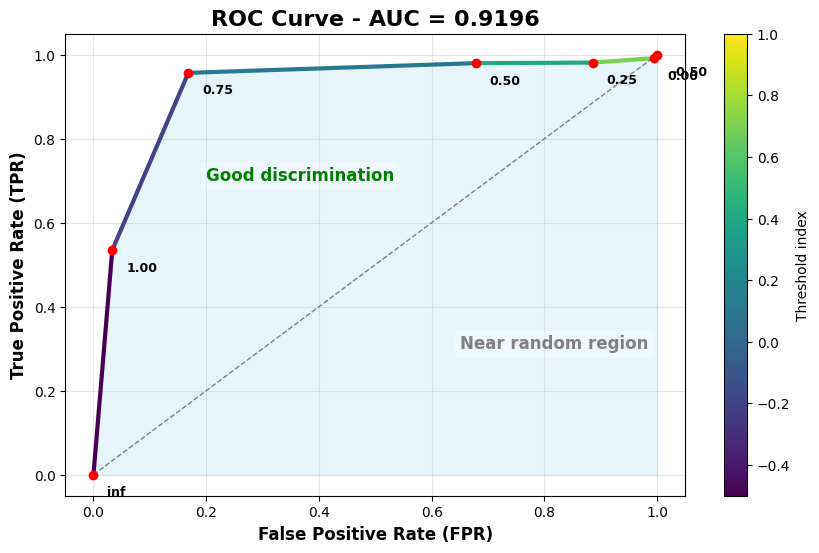

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib.cm import ScalarMappable

# --- Supposons que binary_test_labels et binary_scores existent déjà ---
# binary_test_labels : vraie classe binaire (0 ou 1)
# binary_scores : score de prédiction continu entre 0 et 1

# Calculer FPR, TPR et thresholds
fpr, tpr, thresholds = roc_curve(binary_test_labels, binary_scores)
roc_auc = auc(fpr, tpr)

# Créer figure et axes
fig, ax = plt.subplots(figsize=(10,6))

# Dégradé de couleurs pour la courbe
colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)-1))
for i in range(len(fpr)-1):
    ax.plot(fpr[i:i+2], tpr[i:i+2], color=colors[i], linewidth=3)

# Remplir la zone sous la courbe avec couleur bleu pastel
ax.fill_between(fpr, tpr, alpha=0.2, color='skyblue')

# Ligne diagonale de référence (hasard)
ax.plot([0,1], [0,1], color='gray', linestyle='--', linewidth=1)

# Ajouter points et annotations de seuils (max 10 points)
step = max(1, len(thresholds)//10)
for i in range(0, len(thresholds), step):
    ax.plot(fpr[i], tpr[i], 'o', color='red', markersize=6)
    ax.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]),
                textcoords="offset points", xytext=(10,-15),
                fontsize=9, color='black', fontweight='bold')

# Ajouter textes explicatifs à l’intérieur de la zone colorée
ax.text(0.65, 0.3, 'Near random region', fontsize=12, color='gray', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.3'))
ax.text(0.2, 0.7, 'Good discrimination', fontsize=12, color='green', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.3'))

# Titres et axes (AUC avec 4 décimales)
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
ax.set_title(f'ROC Curve - AUC = {roc_auc:.4f}', fontsize=16, fontweight='bold')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.grid(alpha=0.3)

# Colorbar pour le dégradé
sm = ScalarMappable(cmap='viridis')
sm.set_array(thresholds)
plt.colorbar(sm, ax=ax, label='Threshold index')

plt.show()


In [11]:
import json
from tqdm import tqdm
import re
import torch

batch_size = 40
test_predictions = []
true_labels = []

max_display = 70
displayed = 0
max_retries = 3

for start_idx in tqdm(range(0, len(test_formatted), batch_size), desc="Inference batches"):
    batch = test_formatted.iloc[start_idx:start_idx+batch_size]
    prompts = batch['prompt'].tolist()

    # Tokenisation + envoi sur GPU
    inputs = {k: v.to(model.device) for k, v in tokenizer(
        prompts, return_tensors="pt", truncation=True, padding=True, max_length=1024
    ).items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    # On récupère les prédictions brutes
    predictions = [tokenizer.decode(o, skip_special_tokens=True).strip() for o in outputs]

    # Retry uniquement si la sortie est vide
    retries = 0
    while any(p == "" for p in predictions) and retries < max_retries:
        retries += 1
        invalid_indices = [i for i, p in enumerate(predictions) if p == ""]
        if not invalid_indices:
            break

        retry_inputs = {k: v[invalid_indices].to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            retry_outputs = model.generate(
                input_ids=retry_inputs['input_ids'],
                attention_mask=retry_inputs['attention_mask'],
                generation_config=generation_config
            )
        retry_predictions = [tokenizer.decode(o, skip_special_tokens=True).strip() for o in retry_outputs]

        for j, idx in enumerate(invalid_indices):
            predictions[idx] = retry_predictions[j]

    # Affichage + stockage
    for i in range(len(prompts)):
        if displayed < max_display:
            print(f"Prompt:\n{prompts[i]}")
            print(f"Prediction brute: {predictions[i]}\n")
            displayed += 1

        test_predictions.append(predictions[i])  # <- On stocke la prédiction brute
        true_labels.append(int(batch.iloc[i]['completion']))  # labels vrais

print("Inference terminée avec les prédictions brutes.")

Inference batches:   0%|                                                                                     | 1/2319 [00:05<3:20:13,  5.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id=kcytuaMFAxiOl4k1cBeF2A, user_id=--Vu3Gux9nPnLcG9yO_HxA, business_id=gwGLBmNTfIlaTnwFtddbkQ
Review Text: "History: lobster mac cheese was phenomenal. the clam chowder crab cakes are the best in town. the lobster meat was so sweet and fresh. cant wait to go back and try more delicious food. [stars:5]; i love this place! the beer cheese bread bowl is delicious. the gooey, melted cheese is my favorite and the bread is so fresh. they also have a good selection of great tasting beer. my favorite is the bitchin berry when they carry it! [stars:5]; love their delicious selection of mini and jumbo muffins! they always have a seasonal flavor which is cool such as the pumpkin spice during fall time. they also have coffee and blended drinks if youre 

Inference batches:   0%|                                                                                     | 2/2319 [00:07<2:21:56,  3.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id=0rjUJhXYNnxsQdeSF_zxyA, user_id=-1L7ygK8f8GC9elRKCDgDw, business_id=VGN37glLit5oxbHIZ837Ag
Review Text: "History: every sports fan who enjoys a good sandwich which should be every sports fan must come check this place out. its mostly breakfast when im in here and thats because they have a killer bacon egg and cheese for under and its very relaxing when you arent in too much of a rush in the morning. for lunch i recommend a triple decker club sandwich, big enough to satisfy the biggest of appetites. [stars:5]; bought a drink for the lady and i and they came quickly, ordered the poutine with pork gravy, main course was the brasserie braise with oxtail and pork shoulder. meats were both very tender but the polenta wasnt pairing well with it 

Inference batches: 100%|██████████████████████████████████████████████████████████████████████████████████| 2319/2319 [1:53:23<00:00,  2.93s/it]

Inference terminée avec les prédictions brutes.


In [6]:
import json

# Préparer les résultats pour le JSON
results = [
    {
        "prompt": test_formatted.iloc[idx]['prompt'],  # indice global correspondant
        "true_label": true_labels[idx],
        "predicted_label": test_predictions[idx]
    }
    for idx in range(len(test_predictions))
]

# Chemin de sauvegarde
output_path = "./results_predictions_yelppredictionshallucination.json"

# Écriture du fichier JSON
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"\nRésultats sauvegardés dans '{output_path}' ({len(results)} entrées)")

NameError: name 'test_predictions' is not defined

In [7]:
import json

with open("./results_predictions_yelppredictionshallucination.json", "r", encoding="utf-8") as f:
    loaded_results = json.load(f)

print(loaded_results[0])


{'prompt': 'You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.\nReturn only the rating as a single integer from 1 to 5, with no additional text.\n\nReview Info: review_id=kcytuaMFAxiOl4k1cBeF2A, user_id=--Vu3Gux9nPnLcG9yO_HxA, business_id=gwGLBmNTfIlaTnwFtddbkQ\nReview Text: "History: lobster mac cheese was phenomenal. the clam chowder crab cakes are the best in town. the lobster meat was so sweet and fresh. cant wait to go back and try more delicious food. [stars:5]; i love this place! the beer cheese bread bowl is delicious. the gooey, melted cheese is my favorite and the bread is so fresh. they also have a good selection of great tasting beer. my favorite is the bitchin berry when they carry it! [stars:5]; love their delicious selection of mini and jumbo muffins! they always have a seasonal flavor which is cool such as the pumpkin spice during fall time. they also have coffee and blended drinks i

In [14]:
from sklearn.model_selection import train_test_split

# Split directement sur le DataFrame déjà formaté
calibration_formatted, real_test_formatted = train_test_split(
    test_formatted, test_size=0.2, random_state=42
)

# Vérifier
print(calibration_formatted.head())
print(real_test_formatted.head())

                                                  prompt  completion
33739  You are a rating prediction expert. Based on t...           4
11494  You are a rating prediction expert. Based on t...           4
1081   You are a rating prediction expert. Based on t...           5
36718  You are a rating prediction expert. Based on t...           5
44492  You are a rating prediction expert. Based on t...           4
                                                  prompt  completion
89498  You are a rating prediction expert. Based on t...           3
27142  You are a rating prediction expert. Based on t...           4
19468  You are a rating prediction expert. Based on t...           3
29636  You are a rating prediction expert. Based on t...           4
42943  You are a rating prediction expert. Based on t...           5


In [15]:
# Si tes notes sont censées être des entiers 1-5
calibration_formatted['completion'] = calibration_formatted['completion'].astype(int)

# Calcul du fallback
fallback_mean = round(calibration_formatted['completion'].mean())

In [15]:
from tqdm import tqdm
import torch
import re

# Fonction pour extraire la note (1-5) d'une prédiction
def clean_prediction(pred_text, fallback=None):
    """
    Extraire le chiffre 1-5 après le dernier '### Response:'.
    Retourne fallback si aucun chiffre valide n'est trouvé.
    """
    if "### Response:" in pred_text:
        pred_text = pred_text.split("### Response:")[-1].strip()

    digits = re.findall(r"\b[1-5]\b", pred_text)
    if digits:
        return int(digits[0])

    return fallback  # fallback si pas de chiffre valide

# Liste pour stocker les scores de non-conformité (erreurs absolues)
nonconformity_scores = []

max_retries = 3
batch_size = 30

# Utiliser la moyenne des notes du calibration set comme fallback
fallback_mean = round(calibration_formatted['completion'].mean())

# Boucle sur les batches du jeu de calibration
for start_idx in tqdm(range(0, len(calibration_formatted), batch_size), desc="Calibration inference batches"):
    batch = calibration_formatted.iloc[start_idx:start_idx + batch_size]
    prompts = []

    # Préparer les prompts
    for prompt_text in batch['prompt']:
        if "### Response:" in prompt_text:
            prompt_text = prompt_text.split("### Response:")[0].strip() + "### Response:\n"
        prompts.append(prompt_text)

    # Tokenisation et passage sur GPU
    inputs = tokenizer(prompts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Génération des prédictions
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    # Parcours des sorties
    for i, output in enumerate(outputs):
        prediction = tokenizer.decode(output, skip_special_tokens=True)
        pred_note = clean_prediction(prediction, fallback_mean)

        # Relances si note invalide
        retries = 0
        while (pred_note not in [1, 2, 3, 4, 5]) and retries < max_retries:
            retries += 1
            with torch.no_grad():
                new_output = model.generate(
                    input_ids=inputs['input_ids'][i].unsqueeze(0),
                    attention_mask=inputs['attention_mask'][i].unsqueeze(0),
                    generation_config=generation_config
                )
            prediction = tokenizer.decode(new_output[0], skip_special_tokens=True)
            pred_note = clean_prediction(prediction, fallback_mean)

        # Vraie note pour LLM
        true_label = int(batch.iloc[i]['completion'])
        error = abs(pred_note - true_label)
        nonconformity_scores.append(error)

print("Nombre de scores de non-conformité calculés :", len(nonconformity_scores))

Calibration inference batches: 100%|██████████████████████████████████████████████████████████████████████████████████| 2474/2474 [1:33:30<00:00,  2.27s/it]

Nombre de scores de non-conformité calculés : 74196


In [16]:
import json

# Sauvegarde des scores de non-conformité dans un fichier JSON
output_ncm_path = "./nonconformity_scoresHallucination_yelp.json"

with open(output_ncm_path, "w", encoding="utf-8") as f:
    json.dump(nonconformity_scores, f, ensure_ascii=False, indent=4)

print(f"Scores de non-conformité sauvegardés dans '{output_ncm_path}' ({len(nonconformity_scores)} entrées)")

Scores de non-conformité sauvegardés dans './nonconformity_scoresHallucination_yelp.json' (74196 entrées)


In [17]:
import json

with open("./nonconformity_scoresHallucination_yelp.json", "r", encoding="utf-8") as f:
    scores = json.load(f)

# Afficher le premier élément
print(scores[0])


3


In [ ]:
from tqdm import tqdm
import torch

# Paramètres
batch_size = 30
max_retries = 3

# fallback_mean = moyenne des labels du jeu de calibration (formaté)
fallback_mean = round(calibration_formatted['completion'].astype(int).mean())

prediction_intervals_all = []  # Liste pour stocker les intervalles pour tous les epsilon
predicted_ratings = []         # Liste pour stocker les prédictions du modèle

# Boucle sur le test réel issu du split
for start_idx in tqdm(range(0, len(real_test_formatted), batch_size), desc="Test inference batches"):
    batch = real_test_formatted.iloc[start_idx:start_idx + batch_size]
    prompts = batch['prompt'].tolist()

    # Tokenisation et passage sur GPU
    inputs = tokenizer(prompts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    for i, output in enumerate(outputs):
        prediction = tokenizer.decode(output, skip_special_tokens=True)
        pred_note = clean_prediction(prediction, fallback_mean)

        # Relances si note invalide
        retries = 0
        while (pred_note not in [1, 2, 3, 4, 5]) and retries < max_retries:
            retries += 1
            with torch.no_grad():
                new_output = model.generate(
                    input_ids=inputs['input_ids'][i].unsqueeze(0),
                    attention_mask=inputs['attention_mask'][i].unsqueeze(0),
                    generation_config=generation_config
                )
            prediction = tokenizer.decode(new_output[0], skip_special_tokens=True)
            pred_note = clean_prediction(prediction, fallback_mean)

        predicted_ratings.append(pred_note)  # <-- sauvegarde la prédiction

        # Calcul des intervalles pour chaque tau
        intervals_for_example = []
        for tau in tau_list:  # tau_list défini précédemment à partir du calibration set
            lower = max(1, int(round(pred_note - tau)))
            upper = min(5, int(round(pred_note + tau)))
            intervals_for_example.append((lower, upper))

        prediction_intervals_all.append(intervals_for_example)

print("Intervalles conformes et prédictions générés pour le test réel.")

In [27]:
# import json
# import numpy as np

# # Charger les scores de non-conformité
# with open("./nonconformity_scoresHallucination_yelp.json", "r", encoding="utf-8") as f:
#     nonconformity_scores = np.array(json.load(f))

# # Charger les prédictions de test
# with open("./results_predictions_yelpwithhis.json", "r", encoding="utf-8") as f:
#     results = json.load(f)
# test_predictions = [item["predicted_label"] for item in results]

# # epsilons choisis
# epsilons = [0.1, 0.05, 0.01]

# # Calcul des tau à partir des nonconformity scores
# tau_list = [np.quantile(nonconformity_scores, 1 - epsilon) for epsilon in epsilons]

# # Générer les intervalles conformes
# prediction_intervals_all = []
# for pred in test_predictions:
#     intervals_for_pred = []
#     for tau in tau_list:
#         lower = max(1, int(round(pred - tau)))
#         upper = min(5, int(round(pred + tau)))
#         intervals_for_pred.append((lower, upper))
#     prediction_intervals_all.append(intervals_for_pred)

# # Exemple d'affichage pour le premier élément
# print(f"Prédiction : {test_predictions[0]}, intervalles conformes : {prediction_intervals_all[0]}")


Prédiction : 5, intervalles conformes : [(1, 5), (1, 5), (1, 5)]


In [30]:
import json
import numpy as np

# Charger les scores de non-conformité
with open("./nonconformity_scoresHallucination_yelp.json", "r", encoding="utf-8") as f:
    nonconformity_scores = np.array(json.load(f))

# Charger les prédictions de test
with open("./results_predictions_yelpwithhis.json", "r", encoding="utf-8") as f:
    results = json.load(f)
test_predictions = [item["predicted_label"] for item in results]

# epsilons choisis
epsilons = [0.3, 0.1, 0.05]

# Calcul des tau à partir des nonconformity scores
tau_list = [np.quantile(nonconformity_scores, 1 - epsilon) for epsilon in epsilons]

# Générer les intervalles conformes
prediction_intervals_all = []
for pred in test_predictions:
    intervals_for_pred = []
    for tau in tau_list:
        lower = max(1, int(round(pred - tau)))
        upper = min(5, int(round(pred + tau)))
        intervals_for_pred.append((lower, upper))
    prediction_intervals_all.append(intervals_for_pred)

# Exemple d'affichage pour le premier élément
print(f"Prédiction : {test_predictions[0]}, intervalles conformes : {prediction_intervals_all[0]}")


Prédiction : 5, intervalles conformes : [(2, 5), (1, 5), (1, 5)]


In [31]:
epsilons = [0.3, 0.1, 0.05]

for eps_idx, epsilon in enumerate(epsilons):
    count_in_interval = 0
    for i in range(len(true_labels)):
        lower, upper = prediction_intervals_all[i][eps_idx]  # intervalle pour cet epsilon
        if lower <= true_labels[i] <= upper:
            count_in_interval += 1
    coverage = count_in_interval / len(true_labels)
    print(f"Couverture empirique pour epsilon={epsilon}: {coverage*100:.2f}%")

Couverture empirique pour epsilon=0.3: 98.72%
Couverture empirique pour epsilon=0.1: 99.36%
Couverture empirique pour epsilon=0.05: 99.36%


In [32]:
epsilons = [0.3, 0.1, 0.05]

for eps_idx, epsilon in enumerate(epsilons):
    total_width = 0
    for i in range(len(prediction_intervals_all)):
        lower, upper = prediction_intervals_all[i][eps_idx]  # intervalle pour cet epsilon
        total_width += (upper - lower)  # largeur de l'intervalle
    mean_width = total_width / len(prediction_intervals_all)
    print(f"Largeur moyenne des intervalles pour epsilon={epsilon}: {mean_width:.2f}")

Largeur moyenne des intervalles pour epsilon=0.3: 3.53
Largeur moyenne des intervalles pour epsilon=0.1: 3.98
Largeur moyenne des intervalles pour epsilon=0.05: 3.98


## Hallucination part

In [7]:
import json
from tqdm import tqdm
import torch
import re

# -------------------------
# Extraction STRICTE (sans correction)
# -------------------------
def extract_prediction_strict(pred_text):
    if pred_text is None or pred_text.strip() == "":
        return None, "empty"

    match = re.search(r"### Response:\s*(.*)", pred_text, re.DOTALL)
    if not match:
        return None, "syntaxic"

    response = match.group(1).strip()

    if response.isdigit():
        value = int(response)
        if value in [1,2,3,4,5]:
            return value, "valid"

    return None, "syntaxic"


# -------------------------
# Inference
# -------------------------
batch_size = 47
results = []

for start_idx in tqdm(range(0, len(test_formatted), batch_size), desc="Inference (no-clean / no-retry)"):
    batch = test_formatted.iloc[start_idx:start_idx+batch_size]
    prompts = batch['prompt'].tolist()

    inputs = {k: v.to(model.device) for k, v in tokenizer(
        prompts, return_tensors="pt", truncation=True, padding=True, max_length=1024
    ).items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    for i, output in enumerate(outputs):
        raw_prediction = tokenizer.decode(output, skip_special_tokens=True)

        extracted, status = extract_prediction_strict(raw_prediction)

        results.append({
            "prompt": prompts[i],
            "true_label": int(batch.iloc[i]['completion']),
            "raw_prediction": raw_prediction,
            "predicted_value": extracted,
            "hallucination_type": status
        })


# -------------------------
# Sauvegarde
# -------------------------
output_path = "./results_predictions_raw_hallucinationsyelp_with_hist222.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"\n Résultats sauvegardés dans {output_path} ({len(results)} entrées)")


Inference (no-clean / no-retry): 100%|████████████████████████████████████████████| 1974/1974 [2:23:21<00:00,  4.36s/it]



 Résultats sauvegardés dans ./results_predictions_raw_hallucinationsyelp_with_hist222.json (92745 entrées)


In [8]:
import json
import pandas as pd

with open("./results_predictions_raw_hallucinationsyelp_with_hist222.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,prompt,true_label,raw_prediction,predicted_value,hallucination_type
0,You are a rating prediction expert. Based on t...,5,You are a rating prediction expert. Based on t...,5.0,valid
1,You are a rating prediction expert. Based on t...,5,You are a rating prediction expert. Based on t...,5.0,valid
2,You are a rating prediction expert. Based on t...,5,You are a rating prediction expert. Based on t...,5.0,valid
3,You are a rating prediction expert. Based on t...,5,You are a rating prediction expert. Based on t...,5.0,valid
4,You are a rating prediction expert. Based on t...,5,You are a rating prediction expert. Based on t...,5.0,valid


In [9]:
# -------------------------
# Statistiques d'hallucinations
# -------------------------
hallucination_types = [r["hallucination_type"] for r in results]

total = len(hallucination_types)
syntaxic_count = hallucination_types.count("syntaxic")
empty_count = hallucination_types.count("empty")
valid_count = hallucination_types.count("valid")

syntaxic_pct = (syntaxic_count / total) * 100
empty_pct = (empty_count / total) * 100
valid_pct = (valid_count / total) * 100

print(f"Total prédictions       : {total}")
print(f"Valid (1-5)             : {valid_count} ({valid_pct:.2f}%)")
print(f"Syntaxic hallucinations : {syntaxic_count} ({syntaxic_pct:.2f}%)")
print(f"Empty predictions       : {empty_count} ({empty_pct:.2f}%)")


Total prédictions       : 92745
Valid (1-5)             : 91077 (98.20%)
Syntaxic hallucinations : 1668 (1.80%)
Empty predictions       : 0 (0.00%)


In [10]:
import numpy as np
from collections import Counter

# -------------------------
# Calculer les erreurs absolues pour les prédictions valides
# -------------------------
valid_errors = [
    abs(r['predicted_value'] - r['true_label'])
    for r in results if r['predicted_value'] is not None
]

# Seuil de confiance (70%)
epsilon = 0.3
tau_calibrated = np.quantile(valid_errors, 1 - epsilon)

# Détecter les uncertain
uncertain_count = 0
for r in results:
    if r['predicted_value'] is not None:
        lower = r['predicted_value'] - tau_calibrated
        upper = r['predicted_value'] + tau_calibrated
        if not (lower <= r['true_label'] <= upper):
            r['hallucination_type'] = "uncertain"
            uncertain_count += 1

# Affichage
total = len(results)
print(f"Total des prédictions valides : {len(valid_errors)}")
print(f"Nombre de prédictions uncertain : {uncertain_count}")
print(f"Pourcentage d'uncertain : {uncertain_count/total*100:.2f}%")


Total des prédictions valides : 91077
Nombre de prédictions uncertain : 18574
Pourcentage d'uncertain : 20.03%


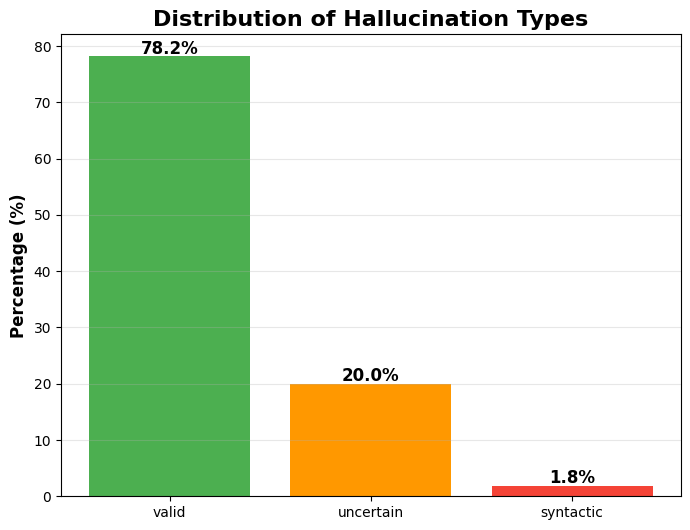

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

# Normaliser les types d'hallucination (syntaxic -> syntactic)
halluc_types = []
for r in results:
    if r['hallucination_type'] == 'syntaxic':
        halluc_types.append('syntactic')
    else:
        halluc_types.append(r['hallucination_type'])

# Compter les types d'hallucination
halluc_counts = Counter(halluc_types)

# Calculer les pourcentages
total = len(halluc_types)
halluc_percent = {k: v / total * 100 for k, v in halluc_counts.items()}

# Couleurs (syntactic reste rouge)
colors = {
    "valid": "#4caf50",        # vert
    "syntactic": "#f44336",    # rouge
    "uncertain": "#ff9800"     # orange
}

# Bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    halluc_percent.keys(),
    halluc_percent.values(),
    color=[colors.get(k, "#2196f3") for k in halluc_percent.keys()]
)

# Ajouter les pourcentages au-dessus des barres
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{height:.1f}%",
        ha="center",
        fontsize=12,
        fontweight="bold"
    )

# Titres et style
ax.set_ylabel("Percentage (%)", fontsize=12, fontweight="bold")
ax.set_title("Distribution of Hallucination Types", fontsize=16, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

plt.show()
